In [20]:
#Code Algorithm

import random,math,numpy
#Generate World:
    #Create Cities, Roads and Evaluate Roads_cost (different than Lenght)
class Edge:

    def __init__(self, origin, dest, cost):
        self.origin = origin
        self.dest = dest
        self.cost = cost
        self.pherom = None

    def getOrigin(self):
        return self.origin

    def getDest(self):
        return self.dest

    def getCost(self):
        return self.cost

    def getPherom(self):
        return self.pherom

    def setPherom(self, pherom):
        self.pherom = pherom

    #Create Graph - Map 
class Graph:

    def __init__(self, num_vertices):
        self.num_vertices = num_vertices # number of vertices/cities
        self.edges = {} # list of edges/roads
        self.neighbours = {} # list of neighbour


    def addEdge(self, origin, dest, cost):
        edge = Edge(origin=origin, dest=dest, cost=cost)
        self.edges[(origin, dest)] = edge
        if origin not in self.neighbours:
            self.neighbours[origin] = [dest]
        else:
            self.neighbours[origin].append(dest)

    def getCostEdge(self, origin, dest):
        return self.edges[(origin, dest)].getCost()

    def getPheromEdge(self, origin, dest):
        return self.edges[(origin, dest)].getPherom()

    def setPheromEdge(self, origin, dest, Pherom):
        self.edges[(origin, dest)].setPherom(Pherom)
        
    def pheromReset(self):
        for edge in self.graph.edges:
            x,y = edge
            self.graph.setPheromEdge(x,y,0.01)

    def getCostTour(self, tour):
        cost = 0
        for i in range(self.num_vertices - 1):
            cost += self.getCostEdge(tour[i], tour[i+1])
        # add last cost
        cost += self.getCostEdge(tour[-1], tour[0])
        return cost

    def generateRandom(self):
        for i in range(1, self.num_vertices + 1):
            for j in range(1, self.num_vertices + 1):
                if i != j:
                    cost = random.randint(1, 10)
                    self.addEdge(i, j, cost)




#Generate Colony:
    # Generate Ant
class Ant:
        #todo create a version, where the Ant know it must visit every city,
        #but it does not know how many or which city exist, only know, 
        #the one it has visited and the ones it can go from there

    def __init__(self, city):
        self.city = city
        self.solution = []
        self.cost = None
        self.available_cities = [] 
        self.visited_cities = []

    def getCity(self):
        return self.city

    def setCity(self, city):
        self.city = city

    def getSolution(self):
        return self.solution

    def setSolution(self, solution, cost):
        # update solution
        if not self.cost:
            self.solution = solution[:]
            self.cost = cost
        else:
            if cost < self.cost:
                self.solution = solution[:]
                self.cost = cost

    def getCostSolution(self):
        return self.cost
    
    def run(self)
        
    

#Find Best Path
class ACO:

    def __init__(self, graph, num_ant, alpha=1.0, beta=5.0, num_gen=10, rho=0.5):
        self.graph = graph
        self.num_ant = num_ant
        self.alpha = alpha # pheromon importance
        self.beta = beta # distance importance
        self.num_gen = num_gen # number of generations of the nest
        self.rho = rho # Evaporation Rate
        self.ants = [] # ants list
    
    # In this function, There will be at least one Ant starting at each city, as long as Number of Ants >= Number of cities
    def setAnts(self):
        list_cities = [city for city in range(1,self.graph.num_vertices+1)]
        aux_list = random.shuffle(list_cities) #randomize list of cities, so each gen have a different composition
        for k in range(num_ant):
            ant_city = aux_list[0]
            aux_list.remove(ant_city) # remove it from the list 
            aux_list.append(ant_city) # append it at the end
            self.ants.append(Ant(ant_city))
            
    
    
    
            
    


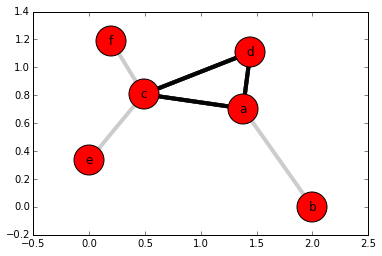

In [125]:
%matplotlib inline
import matplotlib.pylab as mpl
import matplotlib.pyplot as mpl2
import networkx as nx #http://networkx.github.io/documentation/latest/reference
import time

G=nx.Graph()
H=nx.Graph()

#def from implemented to NetworkX.Graph
#graph1 = Graph(5)
#graph1.generateRandom()

#for k in graph1.edges:
#    x,y = k
#    c = graph1.getCostEdge(x,y)
#    G.add_edge(x,y,weight=c)
    
G.add_edge('a','b',weight=1)
G.add_edge('a','c',weight=2)
G.add_edge('c','d',weight=1)
G.add_edge('c','e',weight=4)
G.add_edge('c','f',weight=8)
G.add_edge('d','a',weight=9)

H.add_edge('a','b',weight=7)
H.add_edge('a','c',weight=6)
H.add_edge('c','d',weight=3)
H.add_edge('c','e',weight=5)
H.add_edge('a','f',weight=2)
H.add_edge('d','a',weight=8)

edgelist = [('a','c'),('c','d'),('d','a')]
edgelist2 = [('a','b'),('c','d'),('c','f')]

# nodes G,

pos=nx.spring_layout(G,scale=2)
nx.draw_networkx_nodes(G,pos,node_size=900,hold=1)
nx.draw_networkx_edges(G,pos, width=4,alpha=0.2)
nx.draw_networkx_labels(G,pos)
i =0
while(i < 5):   
    nx.draw_networkx_edges(G,pos, edgelist=edgelist,width=4,alpha=0.5,hold=1)
    name = "fig"+str(i)
    mpl.savefig(name)
    i+=1
#nx.draw_networkx_edges(G,pos, edgelist=edgelist,width=4,alpha=0.5)
#nx.draw_networkx_edges(G,pos, edgelist=edgelist2,width=4,alpha=0.5)



#nx.draw_networkx_nodes(H,pos,node_size=500,node_color='b')
#nx.draw_networkx_edges(H,pos, width=6,alpha=0.2)

mpl2.show()